# Machine Learning-Based Transcriptomic Biomarker Discovery in Huntington's Disease

**Project:** Discovery of Key Biomarkers for Huntington's Disease Using Meta-Analysis and Machine Learning
**Data Source:** GSE64810 (Pre-processed & Filtered)
**Methodology:** **K-Fold Cross-Validation with SMOTE and MCC** for robust evaluation.
**Models:** Random Forest (Feature Selection) & Support Vector Machine (Classification)

---

## 1. Setup and Data Loading
Import necessary libraries and upload the `HD_ML_Ready_Data.csv` file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, matthews_corrcoef
from imblearn.over_sampling import SMOTE # For handling imbalance
from imblearn.pipeline import Pipeline # For cross-validation integrity

# Setup plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
from google.colab import files

print("Please upload 'HD_ML_Ready_Data.csv'")
uploaded = files.upload()

# Check if file is uploaded
filename = list(uploaded.keys())[0]
print(f"Loaded file: {filename}")

data = pd.read_csv(filename)
data.head()

Please upload 'HD_ML_Ready_Data.csv'


Saving HD_ML_Ready_Data.csv to HD_ML_Ready_Data.csv
Loaded file: HD_ML_Ready_Data.csv


,Target_Class,ENSG00000069011.10,ENSG00000163817.11,ENSG00000127083.7,ENSG00000126778.6,ENSG00000166426.7,ENSG00000152779.12,ENSG00000168779.14,ENSG00000096696.9,ENSG00000112303.9,...,ENSG00000042062.7,ENSG00000142973.8,ENSG00000239776.2,ENSG00000196954.8,ENSG00000243449.2,ENSG00000132768.9,ENSG00000203952.5,ENSG00000176845.8,ENSG00000155962.8,ENSG00000115825.5
0,Control,4.071619,6.090280,7.125532,5.382620,7.497715,4.765446,4.765446,6.960278,4.564569,...,8.014083,6.217827,9.888953,7.039835,9.655270,9.433222,6.457747,8.392623,7.597847,9.247964
1,Control,4.071619,5.100674,6.406492,4.765582,7.245451,5.100674,4.765582,7.125984,5.100674,...,7.904945,4.765582,10.152200,7.029189,10.066732,9.761821,6.441144,8.476017,6.995374,9.062880
2,Control,4.421080,6.238176,6.732217,4.765543,7.521798,4.564638,4.673999,6.406381,5.043955,...,7.310590,5.341035,9.219828,6.825564,8.811823,9.315037,6.458025,8.318584,7.424341,9.097114
3,Control,4.071619,6.217818,5.297319,4.564567,7.083328,5.340859,4.421029,6.983465,5.204021,...,7.083328,4.673912,9.573128,7.656120,9.163127,9.010536,6.257690,8.422161,7.698319,8.945244
4,Control,4.071619,6.176926,6.523903,4.564632,7.040122,4.673991,4.845623,6.772973,5.297474,...,7.216359,4.845623,11.759343,6.406355,9.283193,9.370111,6.176926,8.030977,7.166784,8.977201


## 2. Data Preprocessing
Encoding the target variable and setting up the Stratified K-Fold strategy for robust evaluation.

In [3]:
# Separate Features (Genes) and Target
X = data.drop('Target_Class', axis=1)
y = data['Target_Class']

# Encode Target (Control -> 0, HD -> 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Class Mapping: {dict(zip(class_names, le.transform(class_names)))}")
print(f"Control Samples: {np.sum(y_encoded == 0)}, HD Samples: {np.sum(y_encoded == 1)}\n")

# Define K-Fold Strategy (K=5 is a common choice for smaller datasets)
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

print(f"Total Samples: {X.shape[0]}")
print(f"Number of Features (Genes): {X.shape[1]}")
print(f"Using {K}-Fold Stratified Cross-Validation with SMOTE for balance.")

Class Mapping: {'Control': np.int64(0), 'HD': np.int64(1)}
Control Samples: 49, HD Samples: 20

Total Samples: 69
Number of Features (Genes): 200
Using 5-Fold Stratified Cross-Validation with SMOTE for balance.


## 3. Cross-Validation and Model Training
We use **Pipelines** to ensure **SMOTE** (Synthetic Minority Over-sampling Technique) and **Standardization** only happen on the training data within each fold, preventing data leakage. We evaluate using **Matthew Correlation Coefficient (MCC)** for balanced performance assessment.

In [4]:
# Initialize lists to store metrics for each fold
rf_metrics = {'accuracy': [], 'auc': [], 'mcc': []}
svm_metrics = {'accuracy': [], 'auc': [], 'mcc': []}
rf_tpr_list = []
svm_tpr_list = []
mean_fpr = np.linspace(0, 1, 100)
final_rf_pipeline = None # Store the final pipeline for subsequent steps
final_svm_pipeline = None
y_test_final = None

print(f"\n--- Running {K}-Fold Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(skf.split(X, y_encoded)):
    print(f"--- Fold {fold+1}/{K} ---")

    # Split data for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # --- Random Forest with SMOTE Pipeline ---
    # RF does not require scaling, so we just use SMOTE -> RF
    rf_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)), # Oversample minority class (HD)
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    rf_pipeline.fit(X_train, y_train)
    y_pred_rf = rf_pipeline.predict(X_test)
    y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

    # Calculate Metrics
    rf_metrics['accuracy'].append(accuracy_score(y_test, y_pred_rf))
    rf_metrics['auc'].append(roc_auc_score(y_test, y_prob_rf))
    rf_metrics['mcc'].append(matthews_corrcoef(y_test, y_pred_rf))

    # Store ROC curve data for mean plotting
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    rf_tpr_list.append(np.interp(mean_fpr, fpr_rf, tpr_rf))
    rf_tpr_list[-1][0] = 0.0

    # --- SVM with Scaler and SMOTE Pipeline ---
    # SVM requires scaling, so the pipeline ensures scaling is done correctly after splitting and before SMOTE
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()), # Scale is fit ONLY on X_train
        ('smote', SMOTE(random_state=42)),
        ('classifier', SVC(kernel='linear', probability=True, random_state=42))
    ])
    svm_pipeline.fit(X_train, y_train)
    y_pred_svm = svm_pipeline.predict(X_test)
    y_prob_svm = svm_pipeline.predict_proba(X_test)[:, 1]

    # Calculate Metrics
    svm_metrics['accuracy'].append(accuracy_score(y_test, y_pred_svm))
    svm_metrics['auc'].append(roc_auc_score(y_test, y_prob_svm))
    svm_metrics['mcc'].append(matthews_corrcoef(y_test, y_pred_svm))

    # Store ROC curve data for mean plotting
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
    svm_tpr_list.append(np.interp(mean_fpr, fpr_svm, tpr_svm))
    svm_tpr_list[-1][0] = 0.0

    # Store the final pipeline and test data from the last fold for subsequent cells
    final_rf_pipeline = rf_pipeline
    final_svm_pipeline = svm_pipeline
    y_test_final = y_test
    y_pred_rf_final = y_pred_rf
    y_pred_svm_final = y_pred_svm

# Calculate Mean ROC Curves and AUC for visualization and summary
mean_tpr_rf = np.mean(rf_tpr_list, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr, mean_tpr_rf)

mean_tpr_svm = np.mean(svm_tpr_list, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr_svm)


print("\n--- Cross-Validation Summary ---")
print(f"Random Forest Mean Accuracy: {np.mean(rf_metrics['accuracy']):.4f} (+/- {np.std(rf_metrics['accuracy']):.4f})")
print(f"Random Forest Mean MCC: {np.mean(rf_metrics['mcc']):.4f} (+/- {np.std(rf_metrics['mcc']):.4f})")
print(f"Random Forest Mean ROC-AUC: {mean_auc_rf:.4f}")

print(f"SVM Mean Accuracy: {np.mean(svm_metrics['accuracy']):.4f} (+/- {np.std(svm_metrics['accuracy']):.4f})")
print(f"SVM Mean MCC: {np.mean(svm_metrics['mcc']):.4f} (+/- {np.std(svm_metrics['mcc']):.4f})")
print(f"SVM Mean ROC-AUC: {mean_auc_svm:.4f}")


--- Running 5-Fold Cross-Validation ---
--- Fold 1/5 ---
--- Fold 2/5 ---
--- Fold 3/5 ---
--- Fold 4/5 ---
--- Fold 5/5 ---

--- Cross-Validation Summary ---
Random Forest Mean Accuracy: 0.9132 (+/- 0.0698)
Random Forest Mean MCC: 0.7872 (+/- 0.1855)
Random Forest Mean ROC-AUC: 0.9695
SVM Mean Accuracy: 0.9418 (+/- 0.0292)
SVM Mean MCC: 0.8643 (+/- 0.0685)
SVM Mean ROC-AUC: 0.9904


## 4. Evaluation and Visualization
Plotting the mean ROC curves from the K-Fold CV runs and presenting the Confusion Matrix and Classification Report from the last fold as an example.

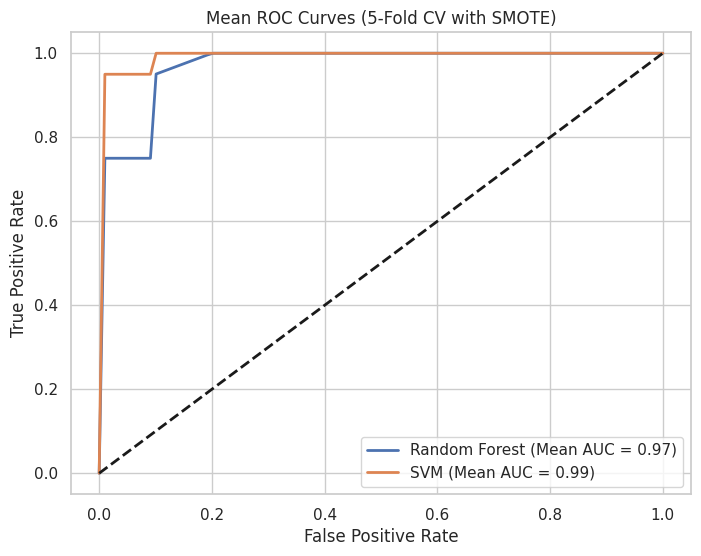

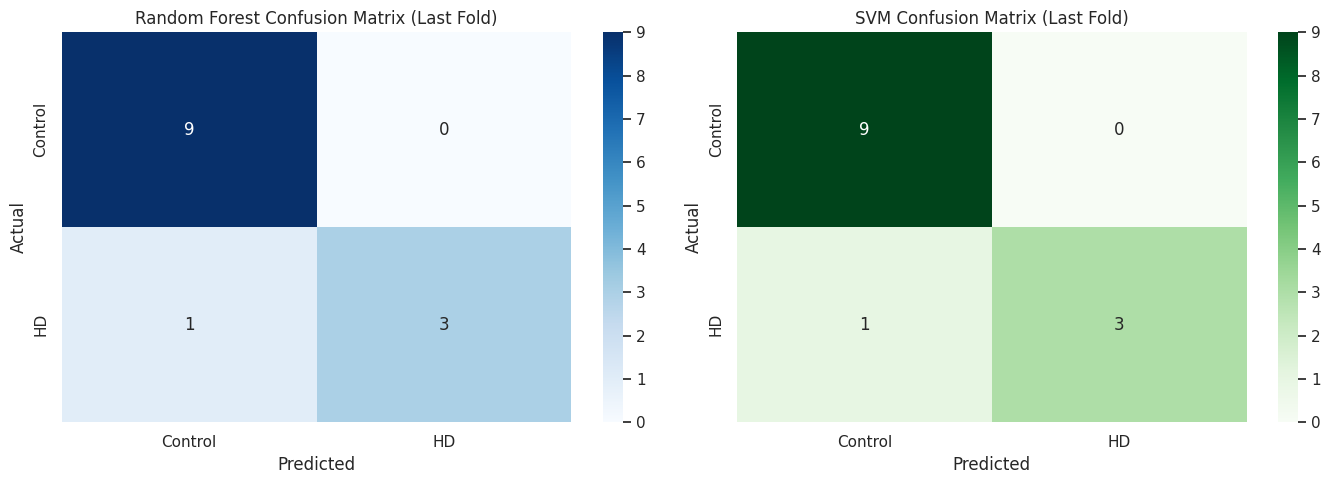


--- Detailed Classification Report (Last Fold) ---
Random Forest MCC: 0.8216
              precision    recall  f1-score   support

     Control       0.90      1.00      0.95         9
          HD       1.00      0.75      0.86         4

    accuracy                           0.92        13
   macro avg       0.95      0.88      0.90        13
weighted avg       0.93      0.92      0.92        13

SVM MCC: 0.8216
              precision    recall  f1-score   support

     Control       0.90      1.00      0.95         9
          HD       1.00      0.75      0.86         4

    accuracy                           0.92        13
   macro avg       0.95      0.88      0.90        13
weighted avg       0.93      0.92      0.92        13



In [5]:
# --- Plot Mean ROC Curves ---
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr_rf, label=f'Random Forest (Mean AUC = {mean_auc_rf:.2f})', lw=2)
plt.plot(mean_fpr, mean_tpr_svm, label=f'SVM (Mean AUC = {mean_auc_svm:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curves (5-Fold CV with SMOTE)')
plt.legend(loc='lower right')
plt.show()

# --- Plot Confusion Matrices (Last Fold Example) ---
cm_rf = confusion_matrix(y_test_final, y_pred_rf_final)
cm_svm = confusion_matrix(y_test_final, y_pred_svm_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Random Forest Confusion Matrix (Last Fold)')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('SVM Confusion Matrix (Last Fold)')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Print detailed Classification Report for the last fold
print("\n--- Detailed Classification Report (Last Fold) ---")
print(f"Random Forest MCC: {matthews_corrcoef(y_test_final, y_pred_rf_final):.4f}")
print(classification_report(y_test_final, y_pred_rf_final, target_names=class_names))

print(f"SVM MCC: {matthews_corrcoef(y_test_final, y_pred_svm_final):.4f}")
print(classification_report(y_test_final, y_pred_svm_final, target_names=class_names))

## 5. Feature Importance (Biomarker Identification)
We extract the feature importance from the Random Forest model trained on the final fold, which identifies the top candidate biomarkers.

/tmp/ipython-input-1275397793.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_genes, palette='viridis')


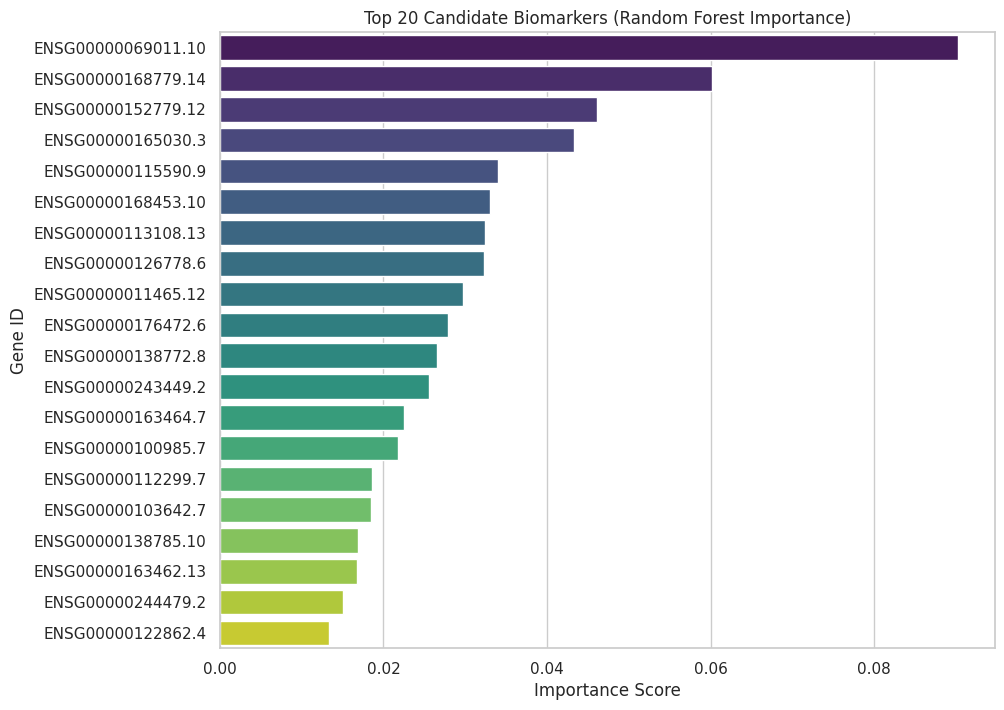

Top 10 Genes:
ENSG00000069011.10: 0.0902
ENSG00000168779.14: 0.0602
ENSG00000152779.12: 0.0461
ENSG00000165030.3: 0.0433
ENSG00000115590.9: 0.0340
ENSG00000168453.10: 0.0330
ENSG00000113108.13: 0.0324
ENSG00000126778.6: 0.0323
ENSG00000011465.12: 0.0297
ENSG00000176472.6: 0.0279


In [6]:
# Extract the classifier step from the final RF pipeline
rf_classifier = final_rf_pipeline.named_steps['classifier']

importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1][:20] # Top 20 features

top_genes = X.columns[indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_genes, palette='viridis')
plt.title('Top 20 Candidate Biomarkers (Random Forest Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Gene ID')
plt.show()

print("Top 10 Genes:")
for gene, score in zip(top_genes[:10], top_importances[:10]):
    print(f"{gene}: {score:.4f}")

## 6. Save and Download Models
We save the final trained pipelines (which contain the SMOTE and Classifier steps) along with the feature names and encoder for future use and deployment.

In [7]:
# Create a directory for artifacts
!mkdir -p hd_models

# 1. Save Random Forest Pipeline (includes SMOTE and RF model)
joblib.dump(final_rf_pipeline, 'hd_models/rf_pipeline.pkl')

# 2. Save SVM Pipeline (includes Scaler, SMOTE, and SVM model)
joblib.dump(final_svm_pipeline, 'hd_models/svm_pipeline.pkl')

# 3. Save Feature Names (To ensure future input order matches training)
feature_names = list(X.columns)
joblib.dump(feature_names, 'hd_models/feature_names.pkl')

# 4. Save Label Encoder (To decode 0/1 back to Control/HD)
joblib.dump(le, 'hd_models/label_encoder.pkl')

print("Artifacts saved locally in 'hd_models/' folder.")

# Zip the folder
!zip -r hd_models.zip hd_models

# Download the zip file
files.download('hd_models.zip')

Artifacts saved locally in 'hd_models/' folder.
  adding: hd_models/ (stored 0%)
  adding: hd_models/svm_pipeline.pkl (deflated 19%)
  adding: hd_models/feature_names.pkl (deflated 74%)
  adding: hd_models/label_encoder.pkl (deflated 34%)
  adding: hd_models/rf_pipeline.pkl (deflated 73%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>